## Helpers

In [1]:
%load_ext autoreload
%autoreload 2
from rl4co.envs.routing import CVRPEnv, CVRPGenerator, CVRPTWEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

In [2]:
import numpy as np
data = np.load(r"E:\projects\Masters\Projects\vrp-benchmarks\data\real_cvrp\cvrp_10_single_depot_single_vehicule_sumDemands.npz", allow_pickle=True)

In [3]:
import torch
from tensordict import TensorDict

def dict_to_tensordict(data: dict, map_size = 1000) -> TensorDict:

    num_depots  = int(data.get('num_depots', 1))

    capacity = torch.tensor(data['vehicle_capacities'].astype(np.float32), dtype=torch.float32)
    locs_full = torch.tensor(data['locations'].astype(np.float32)/map_size, dtype=torch.float32)
    demands   = torch.tensor(data['demands'].astype(np.float32)[:,num_depots:]\
                             /data['vehicle_capacities'].astype(np.float32), dtype=torch.float32)

    depot_pos   = locs_full[:,:num_depots].reshape(-1,2)     # shape [num_depots, 2]
    city_pos    = locs_full[:, num_depots:]     # shape [num_cities, 2]

    # 5. Build the TensorDict
    td = TensorDict(
        {
            'capacity': capacity,   # [1,1]
            'demand':   demands,     # [1, num_cities]
            'depot':    depot_pos,      # [1,2] or [1,num_depots,2]
            'locs':     city_pos,       # [1, num_cities, 2]
        },
        batch_size=torch.Size([capacity.shape[0]]),
    )
    return td

In [4]:
# RL4CO env based on TorchRLV
env = CVRPEnv(generator_params={'num_loc': 10})

# Policy: neural network, in this case wit  h encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name,
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env,
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    )

c:\Users\yahia\anaconda3\envs\vrp\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
c:\Users\yahia\anaconda3\envs\vrp\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


## Sanity check

In [61]:
generator = CVRPGenerator(num_loc =10, vehicle_capacity=10)
env = CVRPEnv(generator=generator)
td = env.generator(10)
td

TensorDict(
    fields={
        capacity: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        demand: Tensor(shape=torch.Size([10, 10]), device=cpu, dtype=torch.float32, is_shared=False),
        depot: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        locs: Tensor(shape=torch.Size([10, 10, 2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([10]),
    device=None,
    is_shared=False)

In [93]:
td_data = dict_to_tensordict(data)
td_data

TensorDict(
    fields={
        capacity: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        demand: Tensor(shape=torch.Size([10, 10]), device=cpu, dtype=torch.float32, is_shared=False),
        depot: Tensor(shape=torch.Size([10, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        locs: Tensor(shape=torch.Size([10, 10, 2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([10]),
    device=None,
    is_shared=False)

Problem 1 | Cost: 6.722
Problem 2 | Cost: 5.405


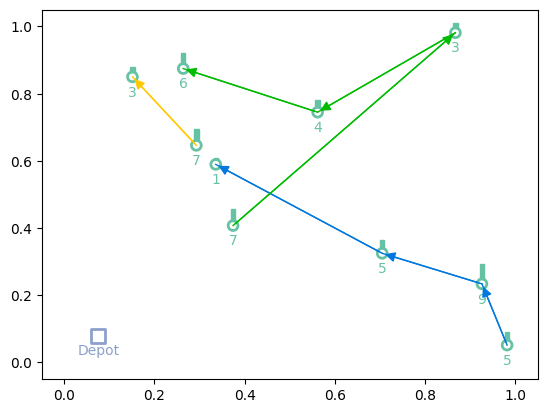

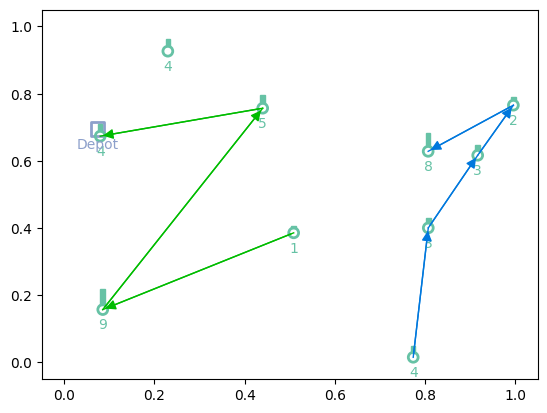

In [114]:
# Greedy rollouts over untrained policy
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(td=td.clone() , batch_size=[10]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(1):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

## Training

In [ ]:
from rl4co.utils.trainer import RL4COTrainer
from rl4co.models    import AttentionModelPolicy, REINFORCE
device_id = 0
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")
generator = CVRPGenerator(num_loc=10)
env = CVRPEnv(generator_params={'num_loc': 10})
policy = AttentionModelPolicy(env_name=env.name,
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env,
                    policy,
                    baseline="rollout",
                    batch_size=50,
                    train_data_size=100_0000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    )

trainer = RL4COTrainer(
        max_epochs=4,
        accelerator="cpu",
        logger=None
    )

trainer.fit(model)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | CVRPEnv              | 0      | train
1 | policy   | AttentionModelPolicy | 694 K  | train
2 | baseline | WarmupBaseline       | 694 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.553     Total estimated model params size (MB)
73        Modules in train mode
69        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Problem 1 | Cost: 3.279
Problem 2 | Cost: 3.502
Problem 3 | Cost: 1.797
Problem 4 | Cost: 2.478
Problem 5 | Cost: 4.278


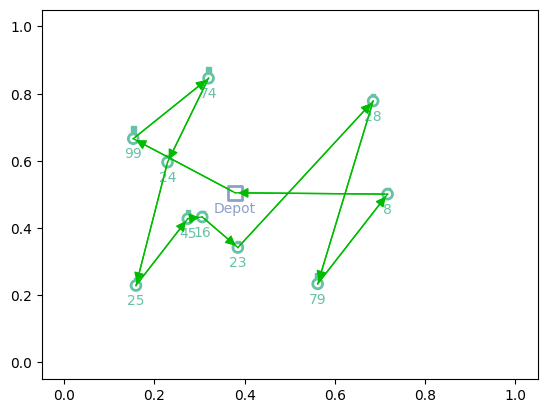

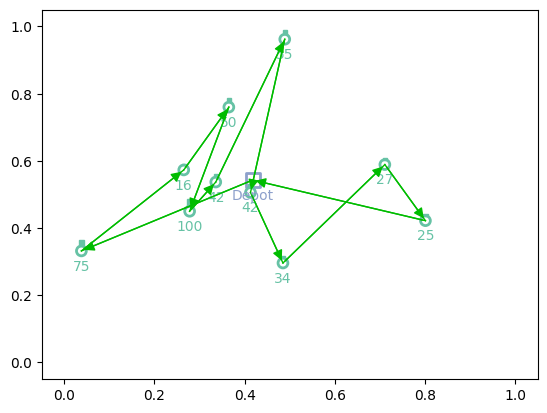

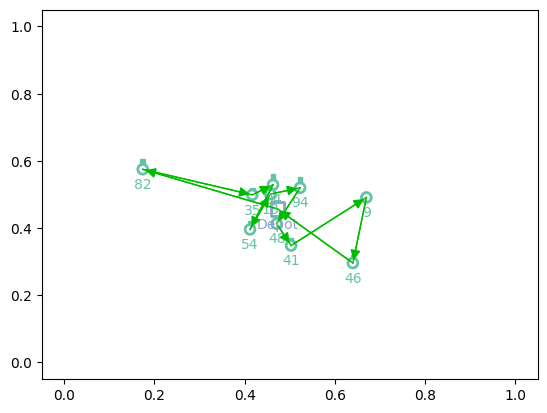

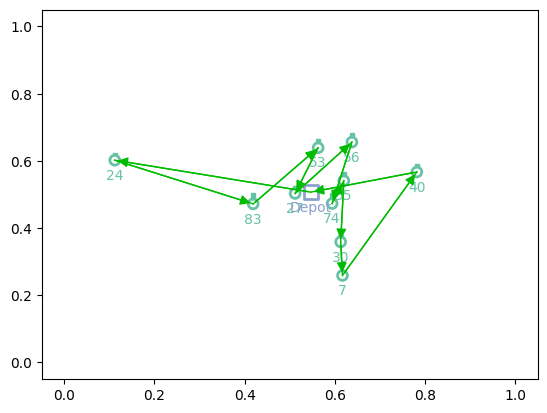

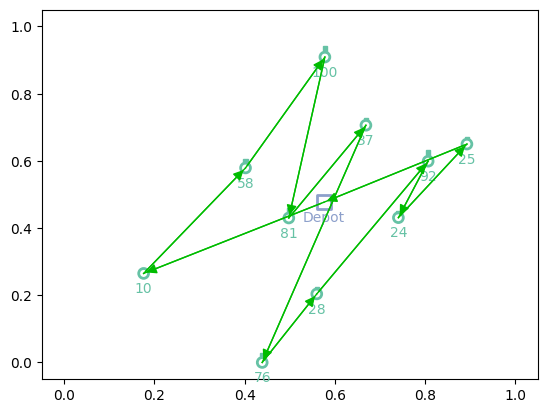

In [8]:
td_data = dict_to_tensordict(data)
td_init = env.reset(td=td_data.clone() ,batch_size=[10])
policy = policy
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(5):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

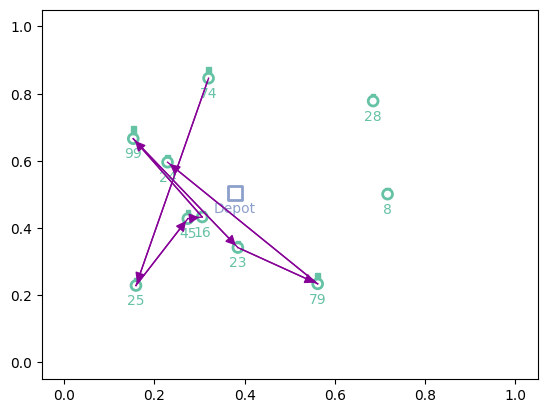

In [51]:
td_init = env.reset(td=td_data.clone() ,batch_size=[10])
env.render(td_init[0], actions_untrained[0])

In [31]:
td_init = env.reset(td=td_data.clone() ,batch_size=[10])
td_init['locs'][0,0,:], td_init['depot'][0,:]

(tensor([0.3790, 0.5050]), tensor([0.3790, 0.5050]))

In [36]:
td_init.keys()

_StringKeys(dict_keys(['capacity', 'demand', 'depot', 'locs', 'current_node', 'used_capacity', 'vehicle_capacity', 'visited', 'action_mask', 'done', 'terminated']))

In [32]:
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

In [45]:
actions_untrained[0]

torch.Size([19])